In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.cluster import HDBSCAN, KMeans
import time
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import calinski_harabasz_score,silhouette_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.decomposition import PCA
from umap import UMAP
import optuna
from algorithms import *

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
c_data =pd.read_parquet(os.path.join(Path.cwd().parent.parent,'data','centroid_spherical_tags.parquet'))
questions = pd.read_pickle(os.path.join(Path.cwd().parent.parent,'data','stackexchange_embeddings.pkl'))
original_data = pd.read_csv(os.path.join(Path.cwd().parent.parent,'data','stackexchange_dataset.csv'))

In [4]:
original_data.index = original_data['question_id']
original_data.drop(columns=['question_id'],inplace=True)

In [22]:
c_data.head(5)

,closest_dist,cluster_mean,tag_embedding,cluster_size,top_5_popular_tags
facebook,0.089584,"[0.004879954, -0.0019050128, -0.016777342, -0....","[0.002688237, 0.015740797, -0.03034449, -0.018...",94,"[instagram-api, instagram, instagram-graph-api..."
integer,0.040206,"[0.027635492, 0.0065359636, -0.0029253308, -0....","[0.03159611, 0.00029558412, -0.006964058, -0.0...",370,"[intervals, differential-equations, math, maxi..."
storage,0.105308,"[0.008282, -0.016636355, -0.0092419945, -0.004...","[0.020607475, -0.017888447, -0.00067037623, -0...",134,"[dicomweb, remotestorage, storage, multipartfo..."
tf-idf,0.070302,"[0.027263727, -0.007913517, 0.0023698097, -0.0...","[0.024365697, -0.010216675, 0.0055818437, -0.0...",243,"[wpml, locale, dictionary, spacy, microsoft-tr..."
qt,0.074746,"[0.01614129, 0.005696066, 0.016760174, -0.0084...","[0.016203284, 0.013681211, 0.018016785, -0.007...",106,"[qt, qml, pyqt, qasync, qt6]"


In [9]:
questions.head(2)

,title_embedding,question_text_embedding
question_id,,
79802517,"[0.008553513, -0.009437113, 0.009673767, -0.02...","[0.0013518566, -0.015674047, -0.004076924, -0...."
79802934,"[0.019479005, 0.007850029, -0.020600174, -0.02...","[0.009473968, -0.014583107, -0.019139914, 0.00..."


In [42]:
original_data.head(2)

,title,has_accepted_answer,accepted_answer_score,time_to_accepted_answer_hours,question_score,question_text,num_tags,tags,accepted_answer_id,accepted_answer_length_chars,accepted_answer_length_tokens
question_id,,,,,,,,,,,
79802517,Looking for a better way using &quot;.Include&...,False,NaN,NaN,2,I am looking for a better way to use the .Incl...,2,"['c#', 'entity-framework']",NaN,NaN,NaN
79802934,NTP is moving my clock further from the correc...,False,NaN,NaN,0,Windows 11 Pro 10.0.26200 Build 26200. Dell XP...,1,['ntp'],NaN,NaN,NaN


In [21]:
c_data

,closest_dist,cluster_mean,tag_embedding,cluster_size,top_5_popular_tags
facebook,0.089584,"[0.004879954, -0.0019050128, -0.016777342, -0....","[0.002688237, 0.015740797, -0.03034449, -0.018...",94,"[instagram-api, instagram, instagram-graph-api..."
integer,0.040206,"[0.027635492, 0.0065359636, -0.0029253308, -0....","[0.03159611, 0.00029558412, -0.006964058, -0.0...",370,"[intervals, differential-equations, math, maxi..."
storage,0.105308,"[0.008282, -0.016636355, -0.0092419945, -0.004...","[0.020607475, -0.017888447, -0.00067037623, -0...",134,"[dicomweb, remotestorage, storage, multipartfo..."
tf-idf,0.070302,"[0.027263727, -0.007913517, 0.0023698097, -0.0...","[0.024365697, -0.010216675, 0.0055818437, -0.0...",243,"[wpml, locale, dictionary, spacy, microsoft-tr..."
qt,0.074746,"[0.01614129, 0.005696066, 0.016760174, -0.0084...","[0.016203284, 0.013681211, 0.018016785, -0.007...",106,"[qt, qml, pyqt, qasync, qt6]"
...,...,...,...,...,...
terraform-provider-aws,0.044895,"[0.015763516, -0.0036154264, -0.003067432, -0....","[0.007955778, -0.01054021, -0.00020258508, -0....",223,"[amazon-web-services, amazon-rds, amazon-ec2, ..."
google-cloud-platform,0.067764,"[0.022253966, 0.0021624626, -0.012489506, -0.0...","[0.027577523, 0.0025372028, -0.016944218, -0.0...",236,"[google-signin, google-apps-script, google-clo..."
azure-management-portal,0.054944,"[0.021838153, 0.0028171865, 0.0024810035, -0.0...","[0.016459106, -0.005079241, 0.00078994414, -0....",216,"[azure-devops, azure-pipelines, azure, azurese..."
kubernetes,0.071019,"[0.014334934, -0.010188106, -0.0025404838, -0....","[0.025267709, -0.0031567314, -0.011494241, -0....",115,"[kubernetes, rancher, istio, service-accounts,..."


In [23]:
'pymacs' in c_data.index.tolist()

True

In [5]:
matcher = DualEncoderMatcher(
    question_embeddings=np.vstack(questions['question_text_embedding'].values),
    tag_embeddings=np.vstack(c_data['cluster_mean'].values),
    tag_names=c_data.index.tolist()
)

In [6]:
questions

,title_embedding,question_text_embedding
question_id,,
79802517,"[0.008553513, -0.009437113, 0.009673767, -0.02...","[0.0013518566, -0.015674047, -0.004076924, -0...."
79802934,"[0.019479005, 0.007850029, -0.020600174, -0.02...","[0.009473968, -0.014583107, -0.019139914, 0.00..."
79802909,"[-0.01977205, 0.0042978777, -0.03637585, -0.01...","[-0.0019663926, -0.024625326, -0.027527379, -0..."
79802932,"[0.020906445, -0.010505062, 0.0033248097, -0.0...","[0.0403566, -0.016648613, 0.0031766212, -0.001..."
79802919,"[0.05319651, 0.0008640268, 0.012939383, -0.001...","[0.06398044, -0.000763149, 0.024764849, 0.0073..."
...,...,...
79662126,"[0.026081964, 0.0014296985, 0.010603848, -0.01...","[0.027758488, 0.014202704, 0.0013608634, 0.008..."
79662912,"[0.01792645, 0.011753886, 0.0029511105, -0.011...","[0.0017172531, 0.017311972, 0.016412362, -0.00..."
79663172,"[0.014135985, -0.008573341, 0.006262712, -0.00...","[0.011241566, -0.004019965, -0.0010910758, -0...."


In [24]:
py_tagged_questions= {}
for i in tqdm(range(len(questions))):
    top_tags = matcher.predict_top_k(i, k=5)
    if 'pymacs' in [tag for tag, _ in top_tags]:
        py_tagged_questions[questions.index[i]] = top_tags


100%|██████████| 99992/99992 [00:35<00:00, 2805.15it/s]


In [25]:
pd_py_tg = pd.DataFrame.from_dict(py_tagged_questions,orient='index',columns=['tag1','tag2','tag3','tag4','tag5'])

In [26]:
pd_py_tg.describe()

,tag1,tag2,tag3,tag4,tag5
count,8605,8605,8605,8605,8605
unique,8605,8605,8605,8605,8605
top,"(pandas, 0.4280793591778543)","(pymacs, 0.3790106523822241)","(pdf-lib.js, 0.3614138933150659)","(datatable, 0.3523168918157834)","(fstream, 0.34965514555141175)"
freq,1,1,1,1,1


In [27]:
pd_py_tg.index

Index([79802909, 79802796,  6918493, 55515129, 79799821, 79589185, 77222514,
       45877614, 79802834, 38130895,
       ...
       71559673, 79663235, 79663207, 29236267, 78454606, 56243269, 75329557,
       38667728, 79659671, 79662912],
      dtype='int64', length=8605)

In [28]:
original_data.head(2).tags

question_id
79802517    ['c#', 'entity-framework']
79802934                       ['ntp']
Name: tags, dtype: object

In [36]:
analysis = pd.DataFrame()

In [37]:
analysis['actual'] = original_data['tags'].apply(lambda x: 1 if 'python' in x else 0)

In [38]:
analysis['predicted'] = original_data.index.isin(pd_py_tg.index).astype(int)

In [39]:
cm = confusion_matrix(analysis['actual'], analysis['predicted'])

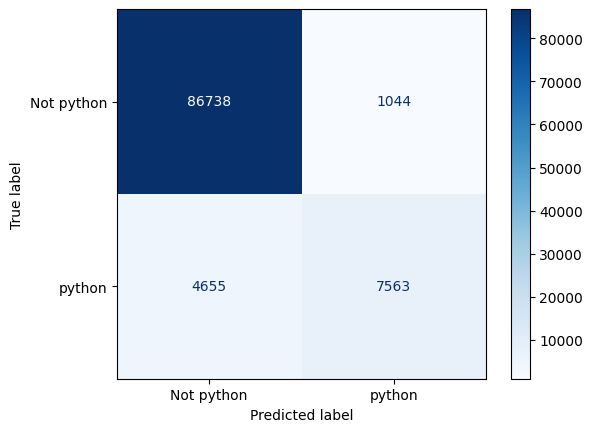

In [40]:
ConfusionMatrixDisplay(cm, display_labels=['Not python','python']).plot(cmap=plt.cm.Blues)
plt.show()

In [41]:
f1_score(analysis['actual'], analysis['predicted'])

0.7263385354141657

---

<Axes: xlabel='question_score'>

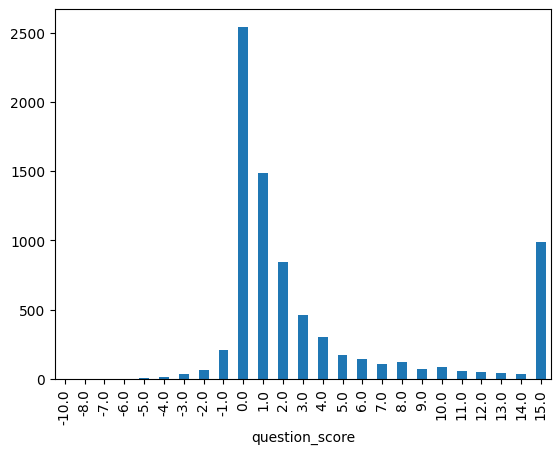

In [121]:
tresh = 15
original_data.loc[pd_py_tg.index].question_score.apply(lambda x: x if abs(x)<=tresh else x/abs(x)*tresh).value_counts().sort_index().plot(kind='bar')

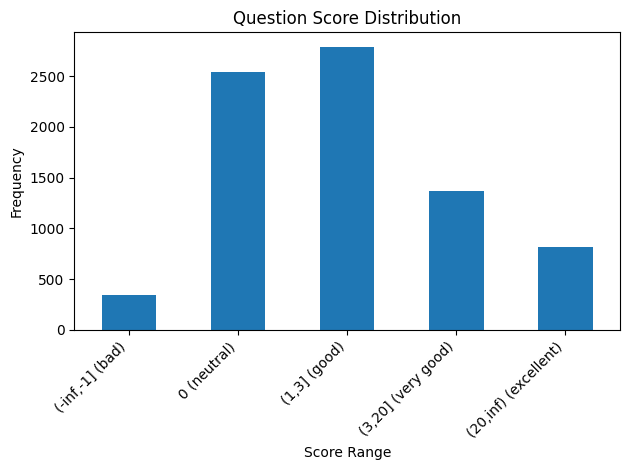

In [122]:
eps = 1e-3
bins = [-np.inf, 0-eps , 0, 3, 20,np.inf]
lbs = ['(-inf,-1] (bad)', '0 (neutral)' ,'(1,3] (good)','(3,20] (very good)','(20,inf) (excellent)']
bin_labels = pd.cut(original_data.loc[pd_py_tg.index].question_score,bins,labels=lbs)
bin_labels.value_counts().sort_index().plot(
    kind='bar',
    title='Question Score Distribution',
    xlabel='Score Range',
    ylabel='Frequency',
    colormap='tab10'
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()